In [1]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [24]:
# lets load the data
df = pd.read_csv('course_ratings.csv')

In [25]:
#lets remove high rating rows
joined = df.drop(df[df['rating'] > 5].index)

In [26]:
# lets define catigorical vars
cat_vars = ['user','course','category','job','institution','state']
#coninuous vars
cont_vars = ['rating']

# df length
n = len(df)

# test percentage
testp = n*.2

#lets update features, categoricial should be category and continuous should be float32
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    joined[v] = joined[v].fillna(0).astype('float32')

In [27]:
# we have to convert all category variables into contiguous ones and save the look up table
lookup_table = {}
for c in cat_vars:
    uq = joined[c].unique()
    col2idx =  {o:i for i,o in enumerate(sorted(uq))}
    lookup_table[c] = col2idx
    joined[c] = joined[c].apply(lambda x: col2idx[x])

In [30]:
# create a test/train set split
joined, joined_test = train_test_split(joined, test_size=0.25)
df = joined.drop('rating', axis=1)
y = joined['rating']
df_test = joined_test.drop('rating', axis=1)

# create a validation set of ids
train_ratio = 0.75
train_size = int(len(df) * train_ratio)
val_idx = list(range(train_size, len(df)))

In [32]:
#final df , everything is numeric and continguous
df.head(10)

,user,course,category,job,institution,state
24148,28071,121,7,12,9,24
53841,21929,36,7,6,14,30
41480,34986,172,7,29,0,24
102240,14875,54,7,6,9,52
149479,12459,120,0,24,14,24
4763,6727,175,7,6,14,41
7973,35387,120,0,6,14,24
107257,5519,3,1,6,0,57
133882,17237,197,0,42,11,35
92895,22644,84,7,6,0,52


In [33]:
#lets build the initial model
md = ColumnarModelData.from_data_frame("models/", val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [34]:
#build embedding matrix, matrices should be 1 bigger then the the number of categorical options to leave room for unknown
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(52118, 50), (220, 50), (15, 8), (46, 23), (16, 8), (61, 31)]

In [35]:
#build the learner, 
# .04 dropout on the embedding matrix
# 1000 and 500 nodes on 2 different layers
# .001 and .01 dropouts
# specifying the range of y (rating) to be 0-5
m = md.get_learner(emb_szs,0 ,0.04, 1, [1000,500], [0.001,0.01],y_range=(0,5))

In [36]:
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 2605900)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 11000)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 8]),
                           ('trainable', True),
                           ('nb_params', 120)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 23]),
                           ('trainable', True),
                           ('nb_params', 1058)])),
             ('Embedding-5',
              OrderedDict([('input_sh

In [37]:
#lets find a learning rate
m.lr_find()

 78%|███████▊  | 604/771 [00:22<00:06, 27.06it/s, loss=1.21] 

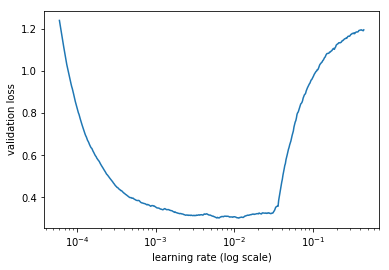

In [38]:
m.sched.plot(100)

In [39]:
lr = 1e-3

In [40]:
# lets fit the model, 50 epochs with restarts
#m.fit(lr, 50, cycle_len=5)

In [ ]:
m.save('mdl')

In [ ]:
m.load('mdl')

In [ ]:
x,y=m.predict_with_targs()

In [ ]:
pred_test=m.predict(is_test=True)

In [ ]:
joined_test['rating_pred'] = pred_test

In [ ]:
joined_test[['rating','rating_pred']]

In [ ]:
rms = sqrt(mean_squared_error(joined_test['rating'], joined_test['rating_pred']))

In [ ]:
# we achieved a root mean squared error of .48
rms

In [ ]:
test_record = df_test.iloc[0]

In [ ]:
joined_test.iloc[0]

In [ ]:
cat = test_record[cat_vars].values.astype(np.int64)[None]
contin = test_record.drop(cat_vars).values.astype(np.float32)[None]

#Prediction
model = m.model
model.eval()
prediction = to_np(model(V(cat),[]))

In [ ]:
prediction[0][0]

In [ ]:
cat